In [1]:
! which python3
! python3 -V

/Users/nick/Dev/magisterka/venv/bin/python3
Python 3.9.6


In [2]:
import typing as t
import jraph
import jax.numpy as jnp
from jax import lax
import networkx as nx
import metadata
import haiku as hk
import utils
import jax
import optax

In [3]:
WINDOW = int(31*24*60/5)
VIS = False

In [4]:
def create_graph_tuple(senders, receivers, edges) -> jraph.GraphsTuple:
    return jraph.GraphsTuple(
        nodes=None,
        edges=edges,
        senders=senders,
        receivers=receivers,
        n_node=jnp.asarray([metadata.NUM_NODES]),
        n_edge=jnp.asarray([metadata.NUM_EDGES]),
        globals=None)

In [5]:
_senders = []
_receivers = []

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
nodes = jnp.array([1] * metadata.NUM_NODES)
edges = jnp.array([1] * metadata.NUM_EDGES)

graph_features = jnp.array([[1]])
graph = create_graph_tuple(senders, receivers, edges)

if VIS:
    utils.draw_jraph_graph_structure(graph)

### Load data

In [6]:
import pandas as pd

In [7]:
df = pd.read_pickle("../data/samples_5m_subset_v1.pkl")

In [8]:
def get_data_for_link(src: str, dst: str, n: int) -> jnp.array:
    ss: pd.Series = df[(df["src_host"] == src) & (df["dst_host"] == dst)]
    return ss.incoming_rate_avg.to_numpy()[:n]

In [9]:
_map = metadata.NODE_IDS_TO_LABELS_MAPPING

_senders = []
_receivers = []
_edges = jnp.array([[]])

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _edges = jnp.append(_edges, 
                get_data_for_link(_map[x], _map[y], WINDOW))
                
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
edges = jnp.array(_edges.reshape((metadata.NUM_EDGES, WINDOW)))

In [10]:
graph = create_graph_tuple(senders, receivers, edges)

In [11]:
if VIS:
    utils.draw_jraph_graph_structure(graph)

### Model

In [38]:
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-4
SPLIT = 0.9
BLOCK_SIZE = int(24*60/5)  # 1 day
BATCH_SIZE = 32
SEED = 1237
NUM_TRAINING_STEPS = 1000

In [13]:
n = int(SPLIT * edges.shape[1])
d_train = edges[0][:n]
d_val = edges[0][n:]

In [14]:
d_train = jnp.log(d_train)
d_val = jnp.log(d_val)

In [15]:
d_val.shape, d_train.shape, edges.shape

((893,), (8035,), (15, 8928))

In [16]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class LoopValues(t.NamedTuple):
    tokens: jnp.ndarray
    state: t.Any
    rng_key: jnp.ndarray

Batch = t.Mapping[str, jnp.ndarray]

In [17]:
the_seed = hk.PRNGSequence(SEED)

def get_batch(split: str) -> Batch:
    data = d_train if split == "train" else d_val
    ixs = jax.random.randint(next(the_seed), (BATCH_SIZE, ), 0, len(data) - BLOCK_SIZE)
    x = jnp.stack([data[i:i+BLOCK_SIZE] for i in ixs])
    y = jnp.stack([data[i+1:i+BLOCK_SIZE+1] for i in ixs])
    return {'input': x, 'target': y}

In [18]:
expl_batch = get_batch("train")

In [39]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    # model = hk.DeepRNN([
    #    hk.Linear(HIDDEN_SIZE, name="linear"),
    #     jax.nn.relu,
    #     hk.LSTM(HIDDEN_SIZE, name="lstm1"),
    #     jax.nn.relu,
    #     hk.LSTM(HIDDEN_SIZE, name="lstm2"),
    #     jax.nn.relu,
    #     hk.Linear(1),
    # ])
    model = hk.VanillaRNN(HIDDEN_SIZE)
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

In [40]:
def sequence_loss(batch: Batch) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    batch_size, sequence_length = batch['input'].shape  # (B, T) 

    initial_state = core.initial_state(batch_size)
    _input = jnp.expand_dims(batch['input'], -1) # (B, T, 1) 
    
    logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)
    # logits -> (B, T, 1)
    loss = jnp.mean(jnp.square(logits[:, :, -1] - batch['target']))
    return loss

In [41]:
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state)

In [42]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
initial_params = init_params_fn(next(rng), expl_batch)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state)

In [43]:
loss_fn = jax.jit(loss_fn)

In [44]:
state = update(state, expl_batch)

for step in range(NUM_TRAINING_STEPS):
    train_batch = get_batch("train")
    state = update(state, train_batch)

    if step % 50 == 0:
        eval_batch = get_batch("eval")
        loss = loss_fn(state.params, eval_batch)
        print({
            'step': step,
            'loss': float(loss),
        })

{'step': 0, 'loss': 27.07697296142578}
{'step': 50, 'loss': 1.893117904663086}
{'step': 100, 'loss': 1.7854197025299072}
{'step': 150, 'loss': 1.5991572141647339}
{'step': 200, 'loss': 1.4713588953018188}
{'step': 250, 'loss': 1.3259913921356201}
{'step': 300, 'loss': 1.2625882625579834}
{'step': 350, 'loss': 1.2234253883361816}
{'step': 400, 'loss': 1.1826382875442505}
{'step': 450, 'loss': 1.1363584995269775}


### Generating data from the model

In [25]:
def generate(
    rng_key: jnp.ndarray,
    context: jnp.ndarray,
    sample_length: int,
) -> jnp.ndarray:
    """Draws samples from the model, given an initial context."""
    # assert context.ndim == 1  # No batching for now.
    core = make_network()

    def body_fn(t: int, v: LoopValues) -> LoopValues:
        token = v.tokens[t]
        next_logits, next_state = core(token, v.state)
        key, subkey = jax.random.split(v.rng_key)
        next_token = jax.random.categorical(subkey, next_logits, axis=-1)
        new_tokens = v.tokens.at[t + 1].set(next_token)
        return LoopValues(tokens=new_tokens, state=next_state, rng_key=key)

    batch_size, sequence_length = context.shape  # (B, T) 

    _input = context
    _input = jnp.expand_dims(context, -1) # (B, T, 1) 
    print(f"yes {_input.shape}")
    
    logits, state = hk.dynamic_unroll(core, context, 
                        core.initial_state(None), time_major=False)
    print(2)
    key, subkey = jax.random.split(rng_key)
    first_token = jax.random.categorical(subkey, logits[-1])
    tokens = jnp.zeros(sample_length, dtype=jnp.int32)
    tokens = tokens.at[0].set(first_token)
    initial_values = LoopValues(tokens=tokens, state=state, rng_key=key)
    values: LoopValues = lax.fori_loop(0, sample_length, body_fn, initial_values)

    return values.tokens

In [26]:
_, sample_fn = hk.without_apply_rng(hk.transform(generate))
sample_fn = jax.jit(sample_fn, static_argnums=[3])

In [27]:
context = expl_batch['input']
samples = sample_fn(state.params, next(rng), context, 10)

yes (32, 288, 1)


ValueError: 'vanilla_rnn/linear/w' with retrieved shape (1, 64) does not match shape=[32, 64] dtype=dtype('float32')

### Bad predictions

In [45]:
def pred():
    core = make_network()
    # batch_size, sequence_length = context.shape  # (B, T) 

    initial_state = core.initial_state(32)
    _input = jnp.expand_dims(context, -1) # (B, T, 1) 

    logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)
    return logits

In [46]:
pred_fn = hk.transform(pred)

In [47]:
preds = pred_fn.apply(state.params, next(rng))
preds.shape

(32, 288, 256)

In [48]:
import plotnine as gg

In [49]:
def plot_samples(truth: jnp.ndarray, prediction: jnp.ndarray):
  assert truth.shape == prediction.shape
  df = pd.DataFrame({'truth': truth.squeeze(), 'predicted': prediction.squeeze()}).reset_index()
  df = pd.melt(df, id_vars=['index'], value_vars=['truth', 'predicted'])
  plot = (
      gg.ggplot(df)
      + gg.aes(x='index', y='value', color='variable')
      + gg.geom_line()
  )
  return plot

In [33]:
expl_batch['target'].shape

(32, 288)

In [ ]:
batch_id = 0
preds[batch_id, :, 0]

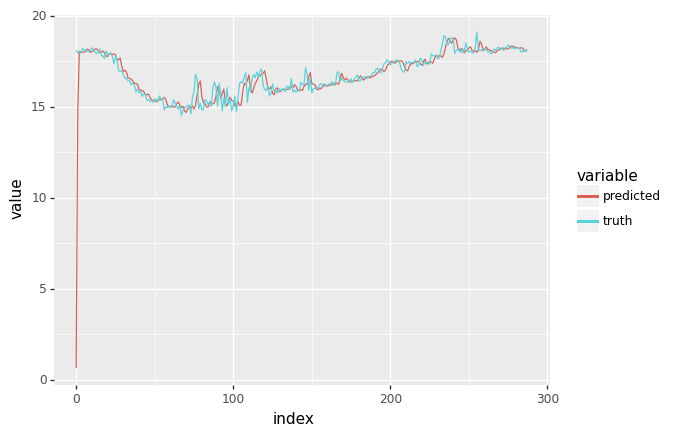

In [57]:
batch_id = 0
plot = plot_samples(expl_batch['target'][batch_id, :], preds[batch_id, :, -1])
plot.draw()